In [124]:
import pandas as pd
import numpy as np 
import os
import sys
sys.path.append('../lib/')
from utils import *
from analysis import * 
import matplotlib.pyplot as plt
from scipy import signal

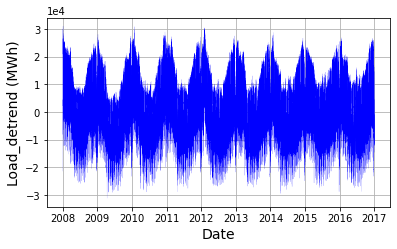

,Date,Hour,Minutes,Load,Load_denoised,Day,Holiday,Day id,Load_detrend,Load_lin_seasonal,Load_real_comp
0,2008-01-01 00:00:00,0.0,30.0,47475.5,47346.803660,1,True,1,-21433.170550,76229.951636,-28883.147976
1,2008-01-01 01:00:00,1.0,22.5,60819.9,60916.440498,1,True,1,-7863.613023,76230.351592,-15313.911094
2,2008-01-01 02:00:00,2.0,22.5,57869.8,57844.668724,1,True,1,-10935.464108,76230.748508,-18386.079784
3,2008-01-01 03:00:00,3.0,22.5,55672.8,55751.026446,1,True,1,-13029.185696,76231.142384,-20480.115938
4,2008-01-01 04:00:00,4.0,22.5,55331.7,55269.909471,1,True,1,-13510.381982,76231.533220,-20961.623749
...,...,...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 19:00:00,19.0,22.5,74952.5,74961.384819,5,False,366,-76.752067,82486.465497,-7525.080678
78908,2016-12-31 20:00:00,20.0,22.5,70390.3,70477.880585,5,False,366,-4560.335612,82486.880648,-12009.000063
78909,2016-12-31 21:00:00,21.0,22.5,66925.1,66827.278809,5,False,366,-8211.016698,82487.292761,-15660.013952
78910,2016-12-31 22:00:00,22.0,22.5,64900.1,64921.358977,5,False,366,-10117.015841,82487.701835,-17566.342858


In [125]:
filepath = '../Data/'
feature = 'Load_detrend'
filename = f'Poland_Load_H_resampled'
df_H = pd.read_csv(filepath + f'{filename}.csv', parse_dates=['Date'])

plot_data(
    df=df_H,
    file=filename,
    lw=0.1,
    feature=feature
)

df_H

In [126]:
x_notrend = df_H['Load_detrend'].to_numpy()
n = x_notrend.size
n_harm = 600

x_freqdom = np.fft.fft(x_notrend)   # signal in frequencies domain
f = np.fft.fftfreq(n)               # frequencies

indexes = list(range(n))
indexes.sort(key= lambda i: np.absolute(f[i]))

t = np.arange(0, n)
restored_sign = np.zeros(t.size)

freq = []
components = []

for i in indexes[1: 1 + n_harm * 2]:
    freq.append(f[i])
    amplitude = np.absolute(x_freqdom[i]) / n
    phase = np.angle(x_freqdom[i])
     
    components.append(amplitude * np.cos(2 * np.pi * f[i] * t + phase))

In [127]:
freq = np.array(freq)
components = np.asarray(components)

KeyboardInterrupt: 

In [ ]:
f_unique = np.unique(np.absolute(freq))
Fourier_comp = np.zeros((f_unique.size, n))

for i, fs in enumerate(f_unique):
    idxs = np.where(np.absolute(freq) == fs)[0]
    if len(idxs) > 1:
        Fourier_comp[i, :] = components[idxs, :].sum(axis=0)
    else:
        Fourier_comp[i, :] = components[idxs]

In [ ]:
FFT_abs = np.absolute(x_freqdom)

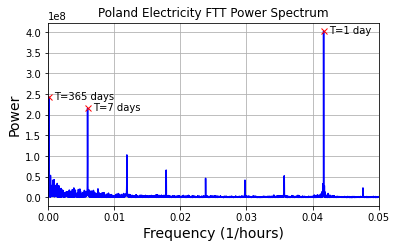

In [ ]:
peaks, _ = signal.find_peaks(FFT_abs, threshold=9.5E6, distance=200)
widths = signal.peak_widths(FFT_abs, peaks, rel_height=0.97)

idxs = [0, 2, 8]
T = np.int32(np.around(1/f[peaks[idxs]]/24))

ax = latex_settings()

ax.plot(f[:n//2], FFT_abs[:n//2], 'b')

ax.plot(f[peaks[idxs]], FFT_abs[peaks[idxs]], 'x', c='red')

for i, t in zip(idxs, T):
    if i == 8:
        string = f'T={t} day'
    else:
        string = f'T={t} days'
    
    ax.annotate(string, xy=(f[peaks[i]], FFT_abs[peaks[i]]),
                    xytext=(f[peaks[i]]+0.0008, FFT_abs[peaks[i]] - 0.5E7))


plt.xlim(0, 0.05)
plt.xlabel('Frequency (1/hours)')
plt.ylabel('Power')
plt.grid()
plt.title('Poland Electricity FTT Power Spectrum')
if os.path.isfile('../Images/Poland_Spectrum.png'):
    pass
else:
    plt.savefig('../Images/Poland_Spectrum.png', dpi=800, transparent=True)

In [ ]:
T_peaks = 1/np.unique(np.abs(f[peaks]))/24.
T_peaks

array([3.65333333e+02, 1.30476190e+01, 6.99574468e+00, 3.50159744e+00,
       2.33356991e+00, 1.74986695e+00, 1.39974457e+00, 1.16678495e+00,
       1.00000000e+00, 8.74933475e-01, 6.36346042e-01, 5.00000000e-01,
       4.66647743e-01, 3.33333333e-01, 2.50000000e-01, 2.00000000e-01])

In [119]:
1/f[np.argmax(FFT_abs)]

24.0

# Frequencies expressed in days 

In [120]:
freq_peaks = []
components_peaks = []

for i in peaks:
    freq_peaks.append(f[i])
    amplitude = np.absolute(x_freqdom[i]) / n
    phase = np.angle(x_freqdom[i])
     
    components_peaks.append(amplitude * np.cos(2 * np.pi * f[i] * t + phase))

In [121]:
T = 1. / (24. * np.unique(np.abs(freq[:])))
T

array([3288.        , 1644.        , 1096.        ,  822.        ,
        657.6       ,  548.        ,  469.71428571,  411.        ,
        365.33333333,  328.8       ,  298.90909091,  274.        ,
        252.92307692,  234.85714286,  219.2       ,  205.5       ,
        193.41176471,  182.66666667,  173.05263158,  164.4       ,
        156.57142857,  149.45454545,  142.95652174,  137.        ,
        131.52      ,  126.46153846,  121.77777778,  117.42857143,
        113.37931034,  109.6       ,  106.06451613,  102.75      ,
         99.63636364,   96.70588235,   93.94285714,   91.33333333,
         88.86486486,   86.52631579,   84.30769231,   82.2       ,
         80.19512195,   78.28571429,   76.46511628,   74.72727273,
         73.06666667,   71.47826087,   69.95744681,   68.5       ,
         67.10204082,   65.76      ,   64.47058824,   63.23076923,
         62.03773585,   60.88888889,   59.78181818,   58.71428571,
         57.68421053,   56.68965517,   55.72881356,   54.8    

In [122]:
Fourier_peaks = np.asarray(components_peaks)
Fourier_peaks.shape

(32,)

In [123]:
T_peaks

array([3.65333333e+02, 1.30476190e+01, 6.99574468e+00, 3.50159744e+00,
       2.33356991e+00, 1.74986695e+00, 1.39974457e+00, 1.16678495e+00,
       1.00000000e+00, 8.74933475e-01, 6.36346042e-01, 5.00000000e-01,
       4.66647743e-01, 3.33333333e-01, 2.50000000e-01, 2.00000000e-01])

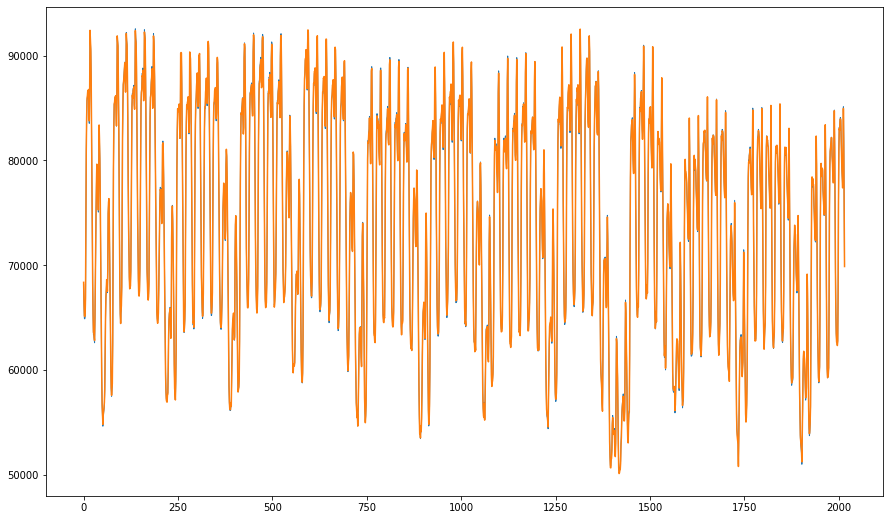

In [105]:
plt.figure(figsize=(15, 9))
Load_deseasonal = df_H.Load.to_numpy() - Fourier_peaks[1:2].sum(axis=0)
plt.plot(Load_deseasonal[96*7-96:96*7*4-96], lw=1)
plt.plot(df_H.Load.to_numpy()[96*7-96:96*7*4-96])

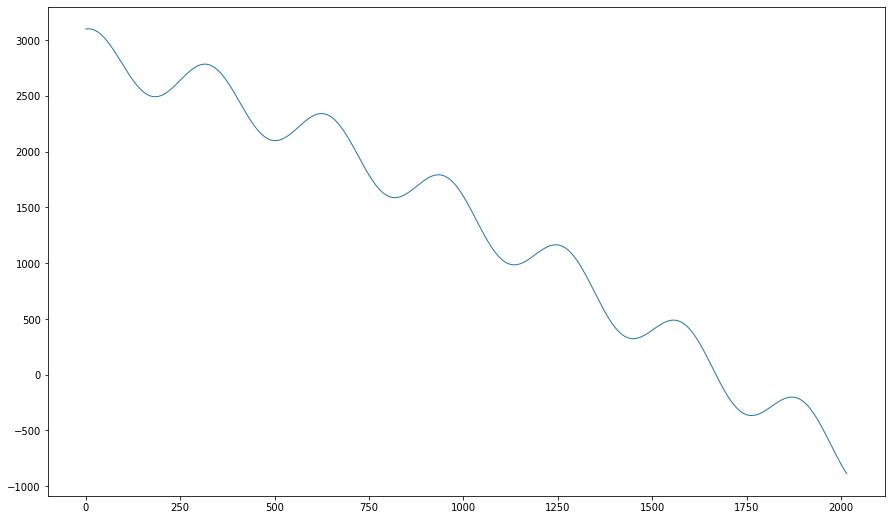

In [103]:
plt.figure(figsize=(15, 9))

Fourier_peaks = np.asarray(components_peaks)
plt.plot(Fourier_peaks[:2].sum(axis=0)[96*7-96:96*7*4-96], lw=1)#[96*7-96:96*7*4-96]

In [29]:
print(3288/365, "years") 

9.008219178082191 years


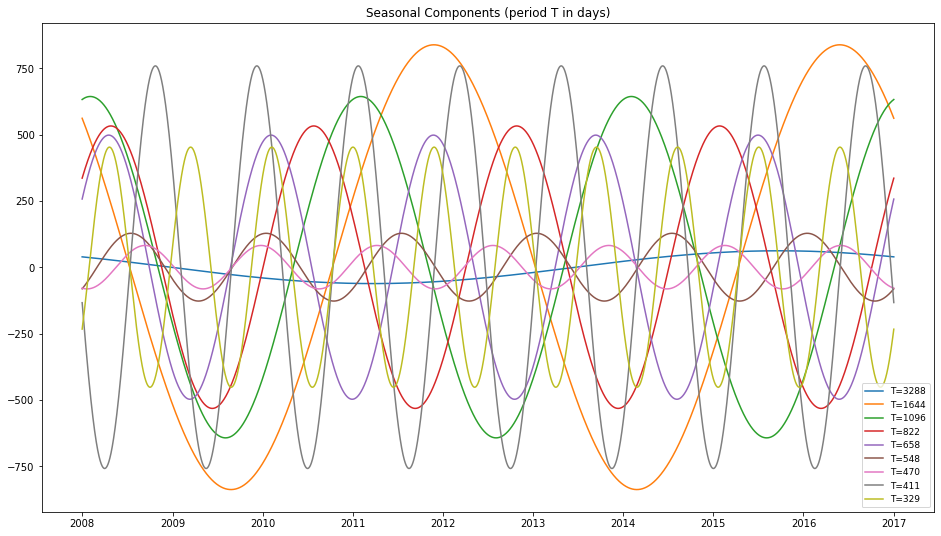

In [31]:
plt.figure(figsize=(16,9))#

mask = np.int32(T) != 365

for component, period in zip(Fourier_comp[mask], T[mask]):
    plt.plot(df_H.Date, component, label=f'T={period:.0f}')
    plt.title("Seasonal Components (period T in days)")
    plt.legend()

In [34]:
nrows = len(T)
df = pd.DataFrame({'n':range(1, nrows+1), 'Freq': np.unique(np.abs(freq[:])), 'Period': np.int32(T)})


df

,n,Freq,Period
0,1,0.000013,3288
1,2,0.000025,1644
2,3,0.000038,1096
3,4,0.000051,822
4,5,0.000063,657
5,6,0.000076,548
6,7,0.000089,469
7,8,0.000101,411
8,9,0.000114,365
9,10,0.000127,328


In [37]:
filename = 'Seasonal_Components.tex'
filepath = '../Results/Latex_tables/'

        
latex_table_generator(df, filepath+filename, float_format='%.2E')